In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.dataset import TrainingSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging

import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.evaluation import eval_net
from torchsummary import summary
from torch_unet.losses import DiceCoeff
from torch_unet.unet.components import Down

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25

val_percent = 0.2
batch_size=1
lr = 0.001
img_scale = 1
epochs = 5

In [3]:
dataset = TrainingSet(IMAGE_DIR, MASK_DIR, mask_treshold=MASK_THRESHOLD)

INFO: Creating dataset with 100 examples


In [4]:
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net = UNet(n_channels=3, n_classes=1, bilinear=False)
net.to(device=device);

INFO: Using device cpu


In [6]:
writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
global_step = 0

In [7]:
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(epochs):
    net.train()   # Sets module in training mode
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)
            
            masks_pred = net(imgs)  # Make predictions
            loss = criterion(masks_pred, true_masks)  # Evaluate loss

            epoch_loss += loss.item()    # Add loss to epoch
            writer.add_scalar('Loss/train', loss.item(), global_step)  

            pbar.set_postfix(**{'loss (batch)': loss.item()})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(imgs.shape[0])
            global_step += 1
            if global_step % (len(dataset) // (10 * batch_size)) == 0:
                val_score = eval_net(net, val_loader, device, n_val)
                logging.info('Validation Dice Coeff: {}'.format(val_score))
                writer.add_scalar('Dice/test', val_score, global_step)

                writer.add_images('images', imgs, global_step)
                if net.n_classes == 1:
                    writer.add_images('masks/true', true_masks, global_step)
                    writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.2, global_step)
writer.close()


In [10]:
from torch_unet.utils import show_side_by_side
datapoint = dataset[0]
image, mask = datapoint['image'].detach().numpy().transpose((1,2,0)), datapoint['mask'].detach().numpy()[0]

0
True


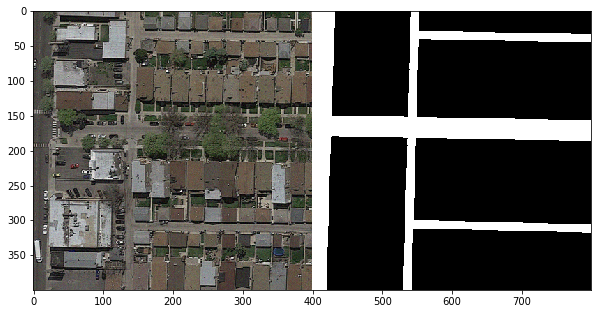

In [11]:
show_side_by_side(image, mask)

In [85]:
def normalize_image(img, _min=0, _max=1):
    image_new = (img - np.min(img))*(_max - _min)/(np.max(img)-np.min(img)) + _min
    return image_new

def gaussian_noise(img, mean, var):
    gaus_noise = np.random.normal(mean, var, img.shape) / 255
    image_n = normalize_image(img + gaus_noise)
    return image_n

def uniform_noise(img, _min, _max):
    uni_noise = np.random.uniform(_min, _max, img.shape) / 255
    image_n = normalize_image(img + uni_noise)
    return image_n

def flip(image, option_value):
    if option_value == 0: # vertical
        image = np.flip(image, option_value)
    elif option_value == 1: # Horizontal
        image = np.flip(image, option_value)
    elif option_value == 2: # Both
        image = np.flip(image, 0)
        image = np.flip(image, 1)
    return image

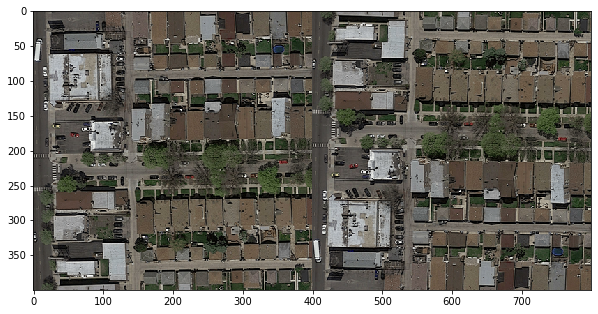

In [90]:
show_side_by_side(image, flip(image, 0))

In [119]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [188]:
y = elastic_transform(image, 100, 100)

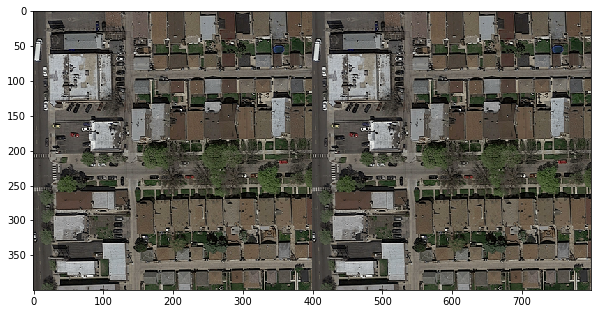

In [189]:
show_side_by_side(image, y)

In [141]:
from torch_unet import data_augmentation

1360

In [185]:
np.random.randint(0, 2)

1

In [191]:
img

array([[[0.34887006, 0.32469126, 0.30798106],
        [0.34682225, 0.31843725, 0.32088302],
        [0.29666053, 0.31737638, 0.29445867],
        ...,
        [0.40965175, 0.40294981, 0.28844866],
        [0.41383199, 0.35516318, 0.28487497],
        [0.43522741, 0.37569691, 0.31486267]],

       [[0.33985072, 0.33403726, 0.32436804],
        [0.3421693 , 0.32604468, 0.3210275 ],
        [0.32839105, 0.32090755, 0.30789262],
        ...,
        [0.41760013, 0.34870517, 0.28659235],
        [0.41773395, 0.36065863, 0.29720573],
        [0.42611171, 0.33982978, 0.28847012]],

       [[0.35879678, 0.30697242, 0.33735391],
        [0.3454554 , 0.35020364, 0.29799266],
        [0.30240768, 0.34051401, 0.27617117],
        ...,
        [0.44197383, 0.33883703, 0.33488741],
        [0.44414652, 0.39167909, 0.32616384],
        [0.43719949, 0.39373109, 0.3379802 ]],

       ...,

       [[0.30917267, 0.31818957, 0.28654517],
        [0.2931953 , 0.32595116, 0.30799738],
        [0.32435976, 0

In [193]:
np.min(y)

0.0